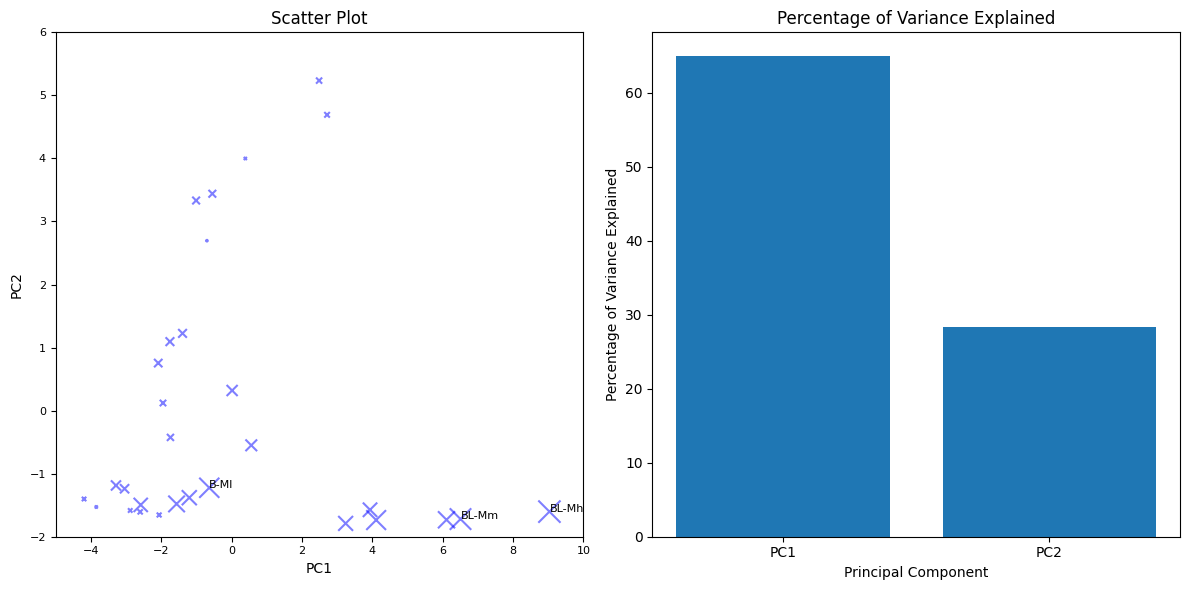

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 
import shap
import xgboost as xgb

from distfit import distfit

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

import utils

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RESPONSE_VARS = ['Limonene']

INPUT_VARS = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU']

DBTL_A = ['2X-Mh', 'B-Lm', '2X-Ll', 'A-Mm', 'B-Ll', 'A-Mh', '2X-Lm',
       'A-Hl', '2X-Hh', 'B-Ml', 'B-Mm', '2X-Lh', 'B-Mh', '2X-Hl', 'B-Hl',
       '2X-Ml', 'B-Hm', 'B-Lh', 'B-Hh', 'A-Ll', 'A-Hm', '2X-Mm', 'A-Hh',
       'A-Ml', 'A-Lm',  'A-Lh', '2X-Hm']

DBTL_B = ['BL-Mm', 'BL-Mh', 'BL-Ml']

df = pd.read_csv('data/preprocessed_data.csv', index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]
data_A = pd.read_csv('data/data_A.csv', index_col=0)
data_B = pd.read_csv('data/data_B.csv', index_col=0)

X_train = data_A[INPUT_VARS]
y_train = data_A[RESPONSE_VARS].values.ravel()
X_test = data_B[INPUT_VARS]
y_test = data_B[RESPONSE_VARS].values.ravel()

# Perform PCA on the training data
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df.drop('Limonene', axis=1)), columns=['PC1', 'PC2'])
pca_df.index = df.index
pca_df['Limonene'] = df['Limonene']


utils.plot_pca(pca_df, pca)

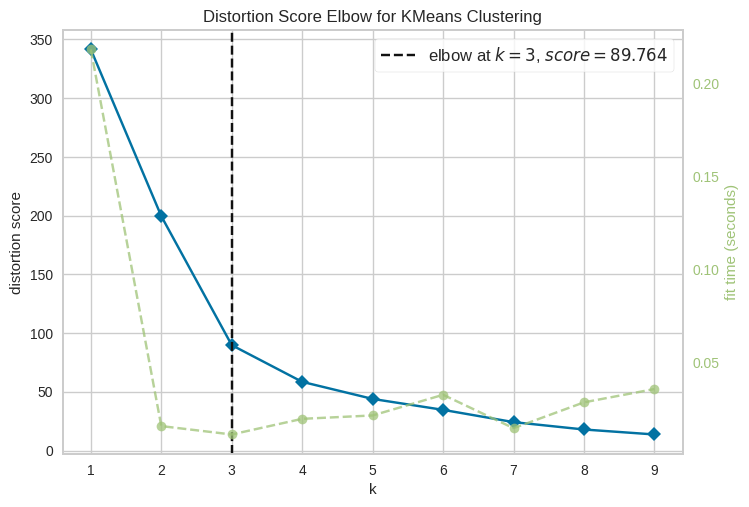

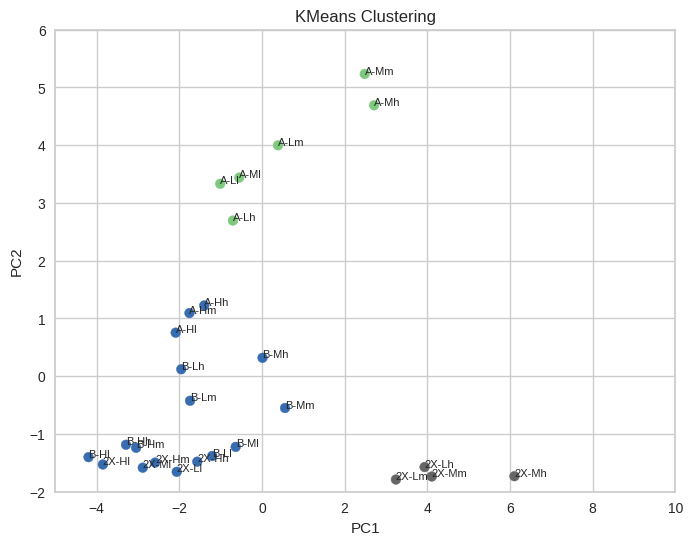

Mean Limonene production of each cluster: 
clusters
0     8.737495
1    29.479046
2    71.793113
Name: Limonene, dtype: float64

Number of points in each cluster: 
1    17
0     6
2     4
Name: clusters, dtype: int64


In [2]:
# Elbow method for KMeans using yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))
visualizer.fit(X_train)
visualizer.show()

model = KMeans(n_clusters=3).fit(X_train)
clusters = model.predict(X_train)
X_train_pca = pd.DataFrame(pca.transform(X_train), columns=['PC1', 'PC2'])
X_train_pca['clusters'] = clusters
X_train_pca['Limonene'] = y_train
X_train_pca.index = X_train.index
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(X_train_pca['PC1'], X_train_pca['PC2'], c=X_train_pca['clusters'], cmap='Accent')
# Label all the points
for i in range(len(X_train_pca)):
    ax.text(X_train_pca.iloc[i, 0], X_train_pca.iloc[i, 1], X_train_pca.index[i], fontsize=8)
ax.set_xlim([-5, 10])
ax.set_ylim([-2, 6])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('KMeans Clustering')
plt.show()

# Calculate the mean of each cluster and number of points in each cluster
print('Mean Limonene production of each cluster: ')
print(X_train_pca.groupby('clusters').mean()['Limonene'])
print()
print('Number of points in each cluster: ')
print(X_train_pca['clusters'].value_counts())

AVG(RMSE) = 31.020026143260512


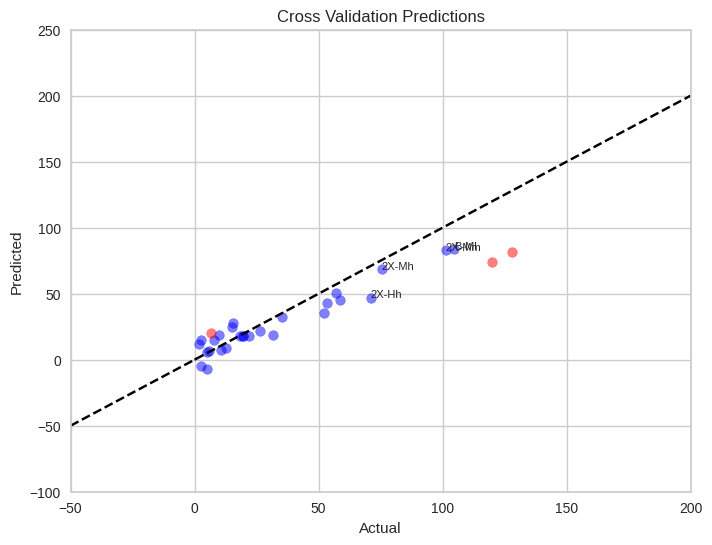

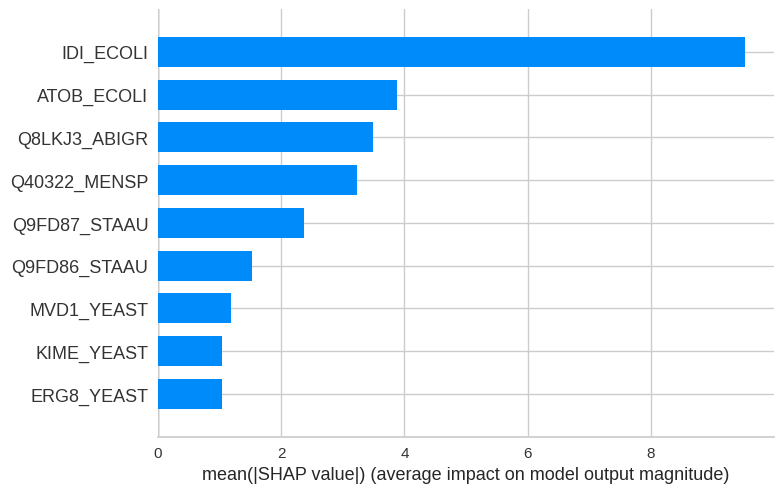

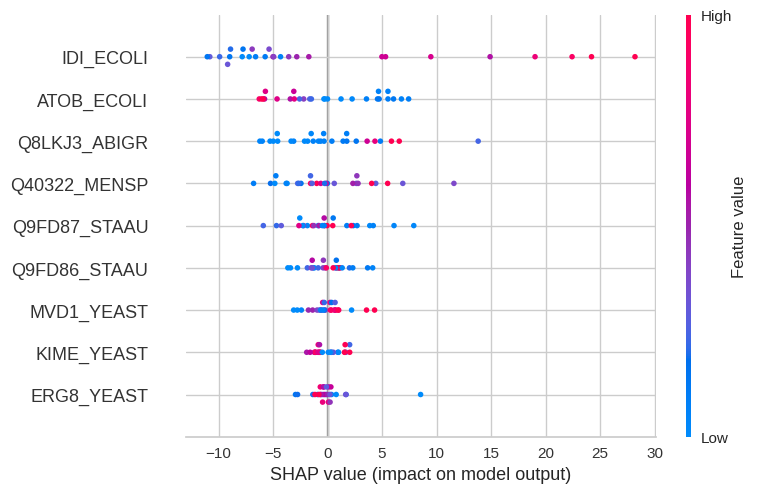

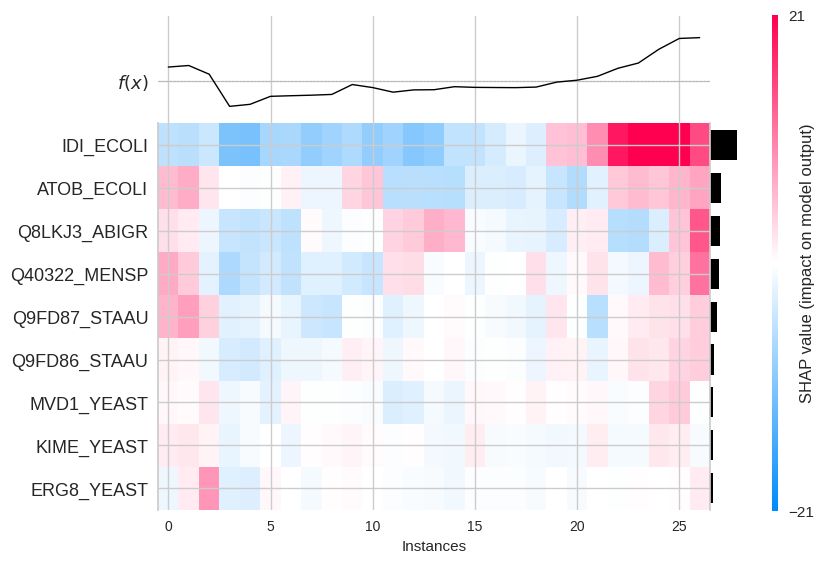

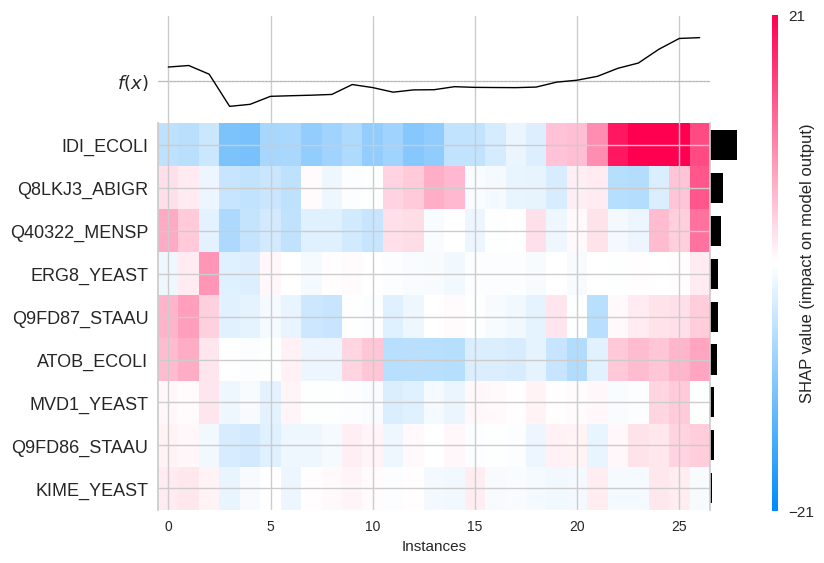

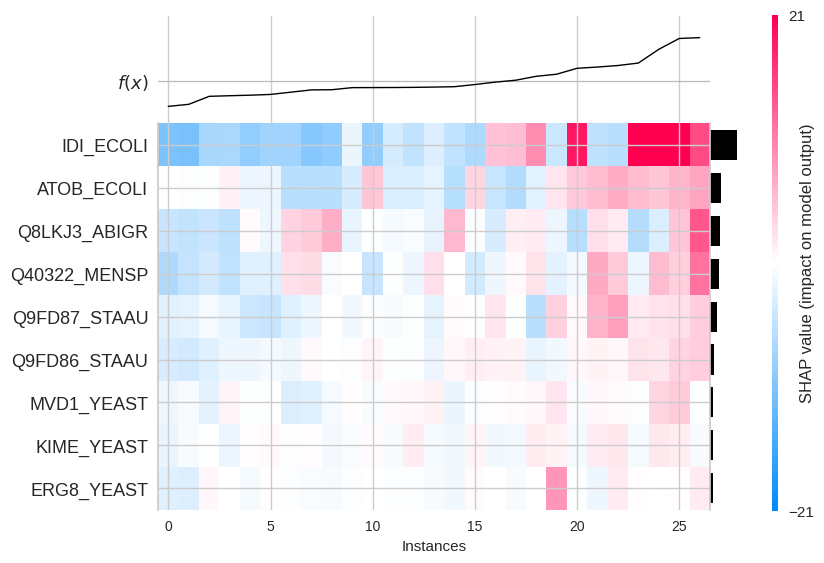

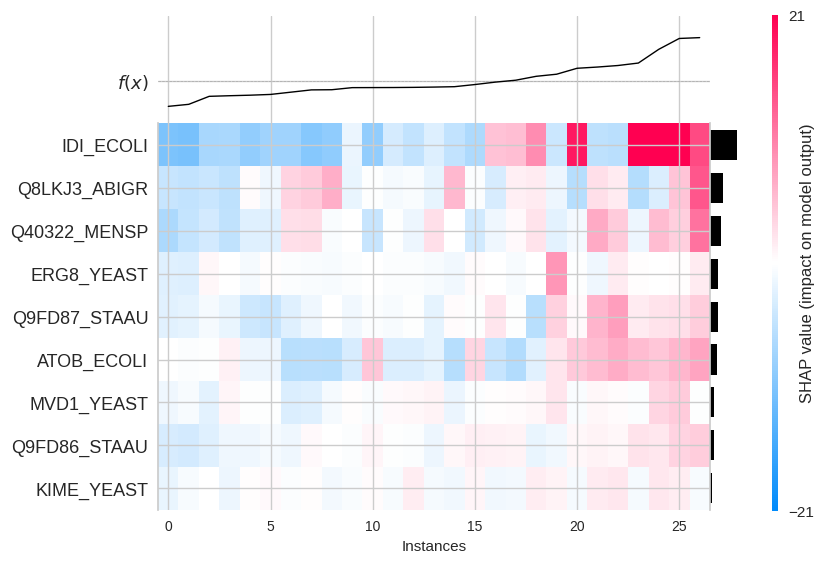

In [3]:
# Stack regressors using sklearn StackingRegressor
estimators = [('rf', RandomForestRegressor()),
                ('svr', SVR())] 

reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
score = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(f'AVG(RMSE) = {np.sqrt(np.abs(score.mean()))}')

# Predict X_test 
y_pred = reg.predict(X_test)

# Real vs Predicted plot for SVR cross validation predictions
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_train, reg.predict(X_train), color='blue', alpha=0.5)
ax.scatter(y_test, y_pred, color='red', alpha=0.5)
ax.set_xlim([-50, 200])
ax.set_ylim([-100, 250])
ax.plot([-50, 200], [-50, 200], color='black', linestyle='--')  # Plotting x=y line
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
for i in range(len(y_train)):
    if y_train[i] > 70:
        ax.text(y_train[i], reg.predict(X_train)[i], X_train.index[i], fontsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Cross Validation Predictions')
plt.show()

# Calculate SHAP values and plot
explainer = shap.Explainer(reg.predict, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')
shap.summary_plot(shap_values, X_train, plot_type='dot')
shap.plots.heatmap(shap_values)
shap.plots.heatmap(shap_values, feature_values=shap_values.abs.max(0))
order = np.argsort(reg.predict(X_train))
shap.plots.heatmap(shap_values, instance_order=order)
shap.plots.heatmap(shap_values, instance_order=order, feature_values=shap_values.abs.max(0))

In [ ]:
X_train_cluster_2 = X_train[X_train_pca['clusters'] == 2]

mensp = np.random.normal(10, 2, 10)
staau_86 = np.random.normal(0.5, 0.1, 10)
staau_87 = np.random.normal(0.5, 0.1, 10)
abigr = np.random.normal(0.24, 0.1, 10)
idi_ecoli = np.random.normal(3, 0.2, 10)
yeast_kime = np.random.normal(0.34, 0.03, 10)
yeast_erg8 = np.random.normal(0.77, 0.13, 10)
atob_ecoli = np.random.normal(0.21, 0.03, 10)
mvd1_yeast = np.random.normal(1.89, 0.24, 10)

x_input = pd.DataFrame({'Q40322_MENSP': mensp, 'Q9FD86_STAAU': staau_86, 'Q9FD87_STAAU': staau_87,
                     'Q8LKJ3_ABIGR': abigr, 'IDI_ECOLI': idi_ecoli, 'KIME_YEAST': yeast_kime,
                     'ERG8_YEAST': yeast_erg8, 'ATOB_ECOLI': atob_ecoli, 'MVD1_YEAST': mvd1_yeast}) 
x_input = x_input[INPUT_VARS]

x_input_pca = pd.DataFrame(pca.transform(x_input), columns=['PC1', 'PC2'])

# Plot PCA
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x_input_pca['PC1'], x_input_pca['PC2'], marker='x', color='black')
plt.scatter(pca_df[pca_df['Limonene'] > 70]['PC1'], pca_df[pca_df['Limonene'] > 70]['PC2'], s=pca_df[pca_df['Limonene'] > 70]['Limonene']*2, color='red', marker='x', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_xlim([-5, 10])
ax.set_ylim([-2, 6])
ax.tick_params(labelsize=8)
ax.set_title('Scatter Plot')
plt.tight_layout()
plt.show()

In [ ]:
X_train_cluster_2 = X_train[X_train_pca['clusters'] == 2]

for row in range(len(X_train_cluster_2)):
    X_train_cluster_2.iloc[row]['Q40322_MENSP'] = np.random.normal(loc=100, scale=10,size=1)
    X_train_cluster_2.iloc[row]['Q9FD87_STAAU'] = np.random.uniform(0, 1)
    X_train_cluster_2.iloc[row]['Q9FD86_STAAU'] = np.random.uniform(0, .52)
    X_train_cluster_2.iloc[row]['IDI_ECOLI'] = np.random.uniform(1, 2)
    X_train_cluster_2.iloc[row]['MVD1_YEAST'] = np.random.uniform(1.5, 4)
    X_train_cluster_2.iloc[row]['Q8LKJ3_ABIGR'] = np.random.uniform(0, 1)
    X_train_cluster_2.iloc[row]['ATOB_ECOLI'] = np.random.uniform(1, 2)
    X_train_cluster_2.iloc[row]['KIME_YEAST'] = np.random.uniform(0.3, 1.4)
    X_train_cluster_2.iloc[row]['ERG8_YEAST'] = np.random.uniform(0, 1)

X_train_cluster_2 = X_train_cluster_2[pca.feature_names_in_]

# PCA plot
new_pca_df = pd.DataFrame(pca.transform(X_train_cluster_2), columns=['PC1', 'PC2'])
new_pca_df.index = X_train_cluster_2.index
# Plot the PCA
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(new_pca_df['PC1'], new_pca_df['PC2'], color='blue', marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_xlim([-5, 10])
ax.set_ylim([-2, 6])
ax.tick_params(labelsize=8)
ax.set_title('Scatter Plot')
plt.tight_layout()
plt.show()

In [ ]:
X_train_cluster_2

In [ ]:
data_B

In [ ]:
1/0

In [ ]:
X_train_cluster_2

In [ ]:
# Create a dataframe similar to X_train but empty
X_design = pd.DataFrame(columns=X_train.columns)



# Add a row of values with values from a list of values
X_design.loc[0] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 2, 3]

In [ ]:
# Generate synthetic data for each feature
X_synthetic = pd.DataFrame()
for col in X_train.columns:
    dist = distfit()
    dist.fit_transform(X_train[col].values, verbose=0)
    X_synthetic[col] = dist.generate(n=1000)  # Produce synthetic data from the given distribution fitted by distfit

# Drop rows with negative values
X_synthetic = X_synthetic[(X_synthetic > 0).all(axis=1)]
X_synthetic['Limonene'] = best_svr.predict(X_synthetic)
print(f'X_synthetic shape: {X_synthetic.shape}')    